## Important 
you need to run the notebook within xvfb (x virtual frame buffer)
`xvfb-run -s "-screen 0 1400x900x24" jupyter notebook`

also make sure you run tensorboard:
`tensorboard --logdir /tmp/tensorboard/`

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame
from include_pycharm_modules import import_source_folders
import_source_folders("/home/kic/sources/private/projects/pandas-quant")

adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-common
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-utils
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-1ntegration-test
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant-data-provider
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant-rl


<IPython.core.display.Javascript object>


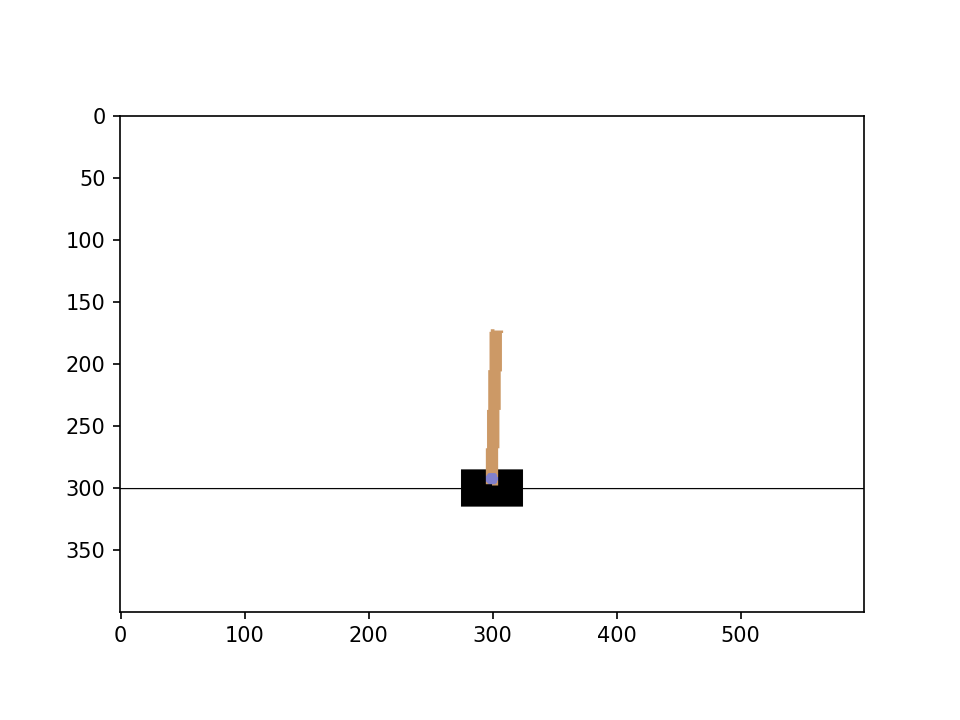

In [2]:
from pandas_ml_quant_rl.environments import CartPoleWrappedEnv
import numpy as np

env = CartPoleWrappedEnv(auto_render_after_steps=100)

s = env.reset()
env.step(np.random.choice(env.action_space.n))
env.render('matplotlib')

<IPython.core.display.Javascript object>


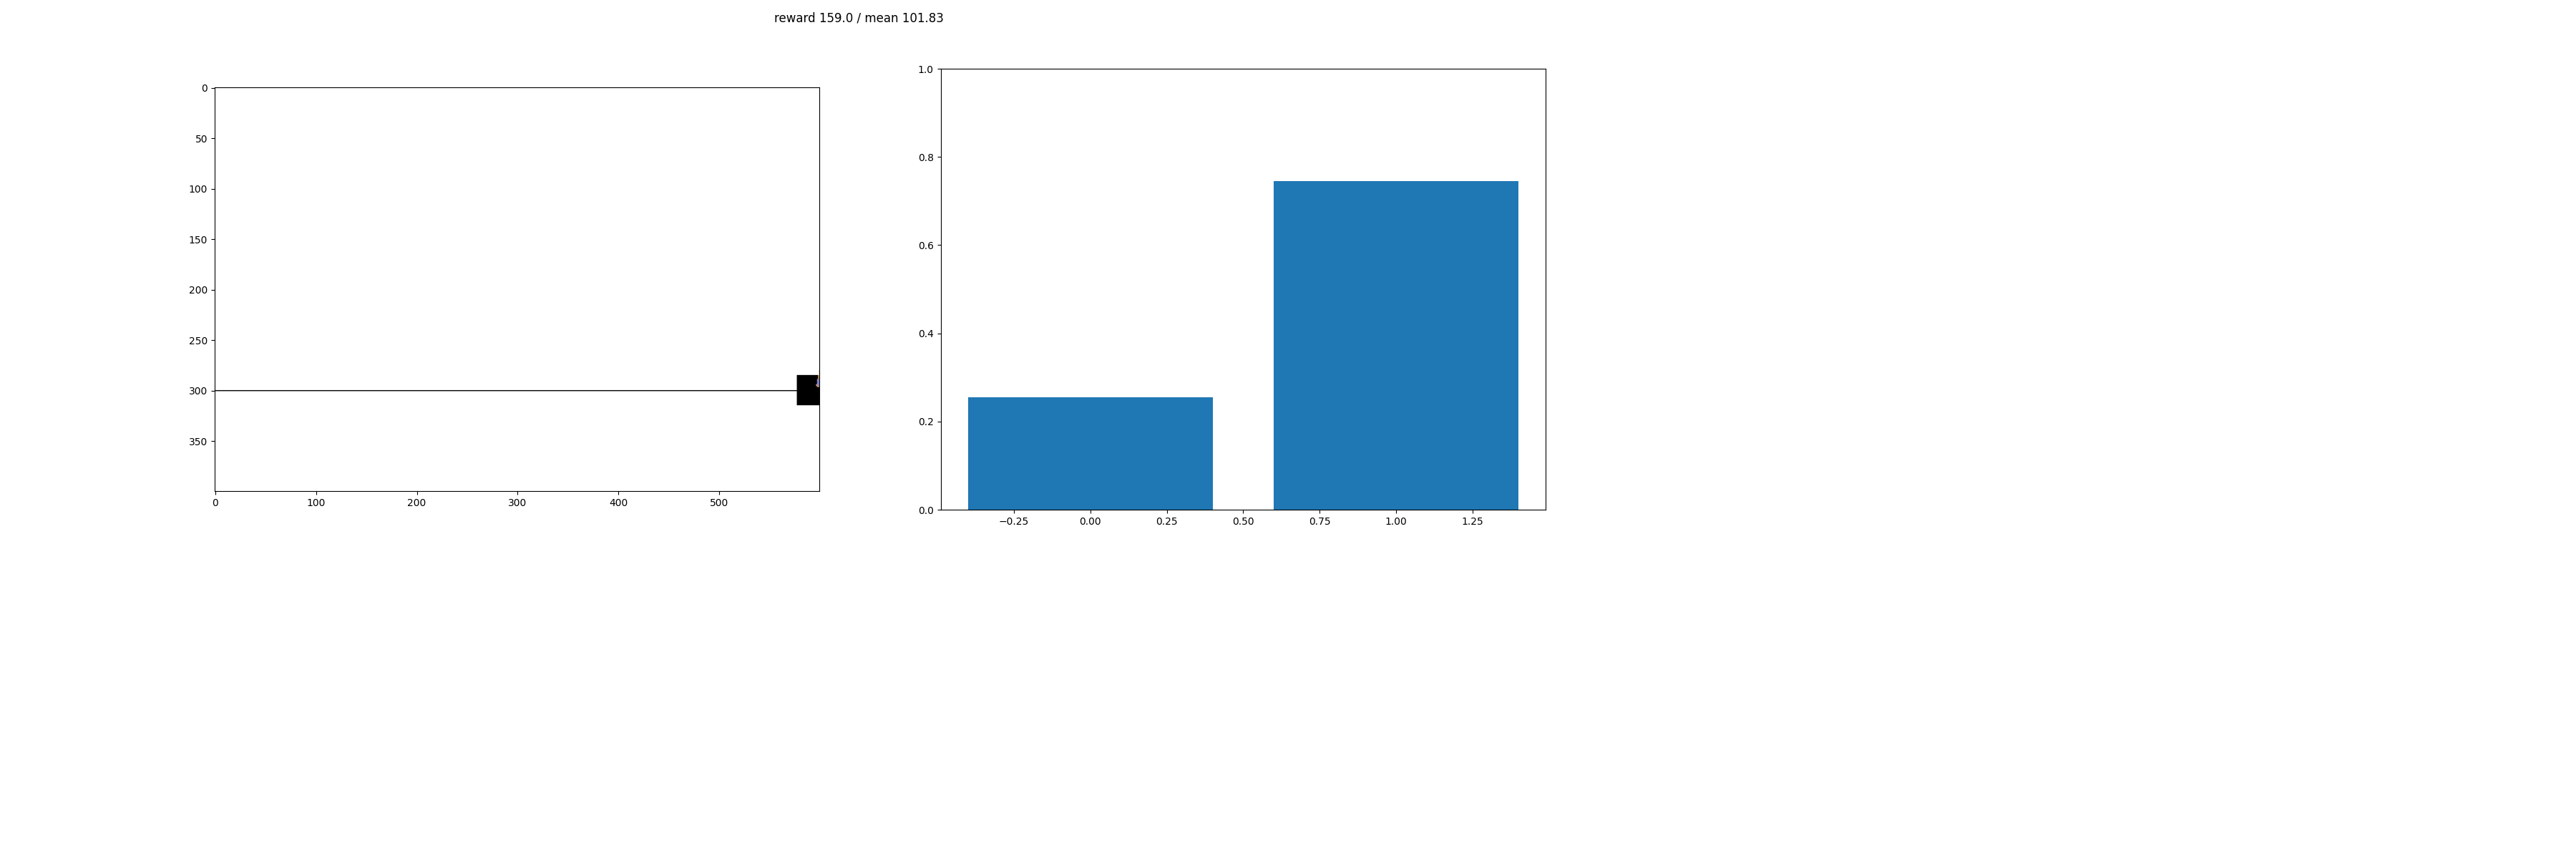

Solved 159.0 (mean 101.83433352288449) in 94 episodes


101.83433352288449

In [3]:
import torch as T
import torch.nn as nn
from torch.optim import RMSprop
from pandas_ml_quant_rl import Agent
from pandas_ml_quant_rl.model.policy.pytorch import PolicyNetwork, DQN_Policy



class DQNet(PolicyNetwork):
    
    def __init__(self, input_size, n_actions):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions),
        )

    def render(self, states, ax):
        probs = self.softmax(self._estimate_action(*states)).detach().cpu().numpy()[-1]
        ax.clear()
        ax.set_ylim(0, 1)
        ax.bar(x=range(len(probs)), height=probs)
        
    def get_value_for(self, states, action):
        return self._estimate_action(*states) \
                   .gather(dim=1, index=T.LongTensor(action).to(self.device).unsqueeze(-1))

    def get_state_value(self, states):
        values = self._estimate_action(*states).detach()
        return values.max(dim=1)
        
    def _estimate_action(self, state, state_2):
        return self.net(state)


policy1 = DQN_Policy(
    lambda: DQNet(env.observation_space.shape[0], 2).cpu(),
    optimizer=lambda p: RMSprop(p),
    batch_size=128,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 150
)

agent1 = Agent(render_nr_actions=-1, render_env=True, render_policy=True)
agent1.learn_to_play(env, policy1, exit_criteria=lambda reward, cnt: reward > 100 or cnt > 500)

In [6]:
IFrame('http://localhost:6006/', width='100%', height='800px')

<IPython.core.display.Javascript object>


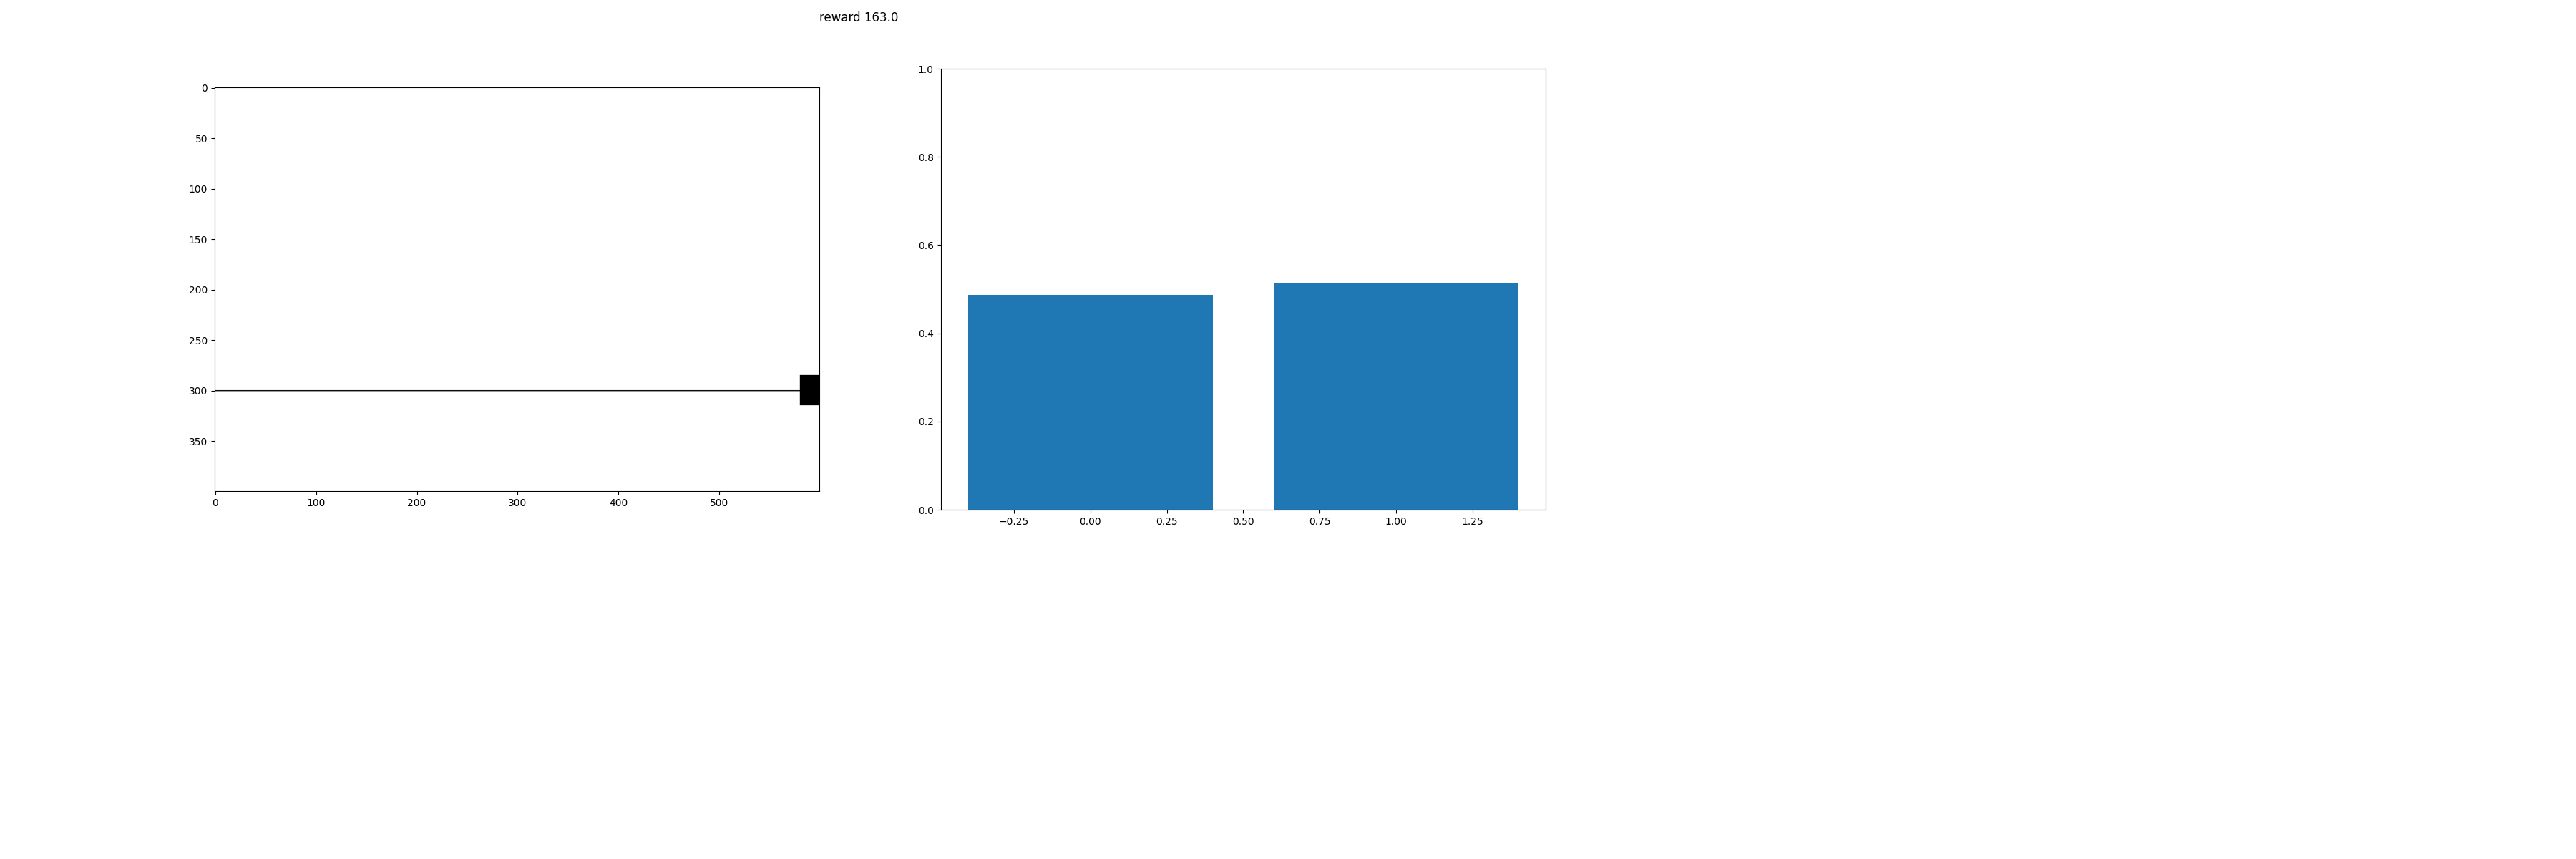

163.0

In [14]:
Agent(render_nr_actions=1, render_env=True, render_policy=True).play_one_episode(env, policy1)

<IPython.core.display.Javascript object>


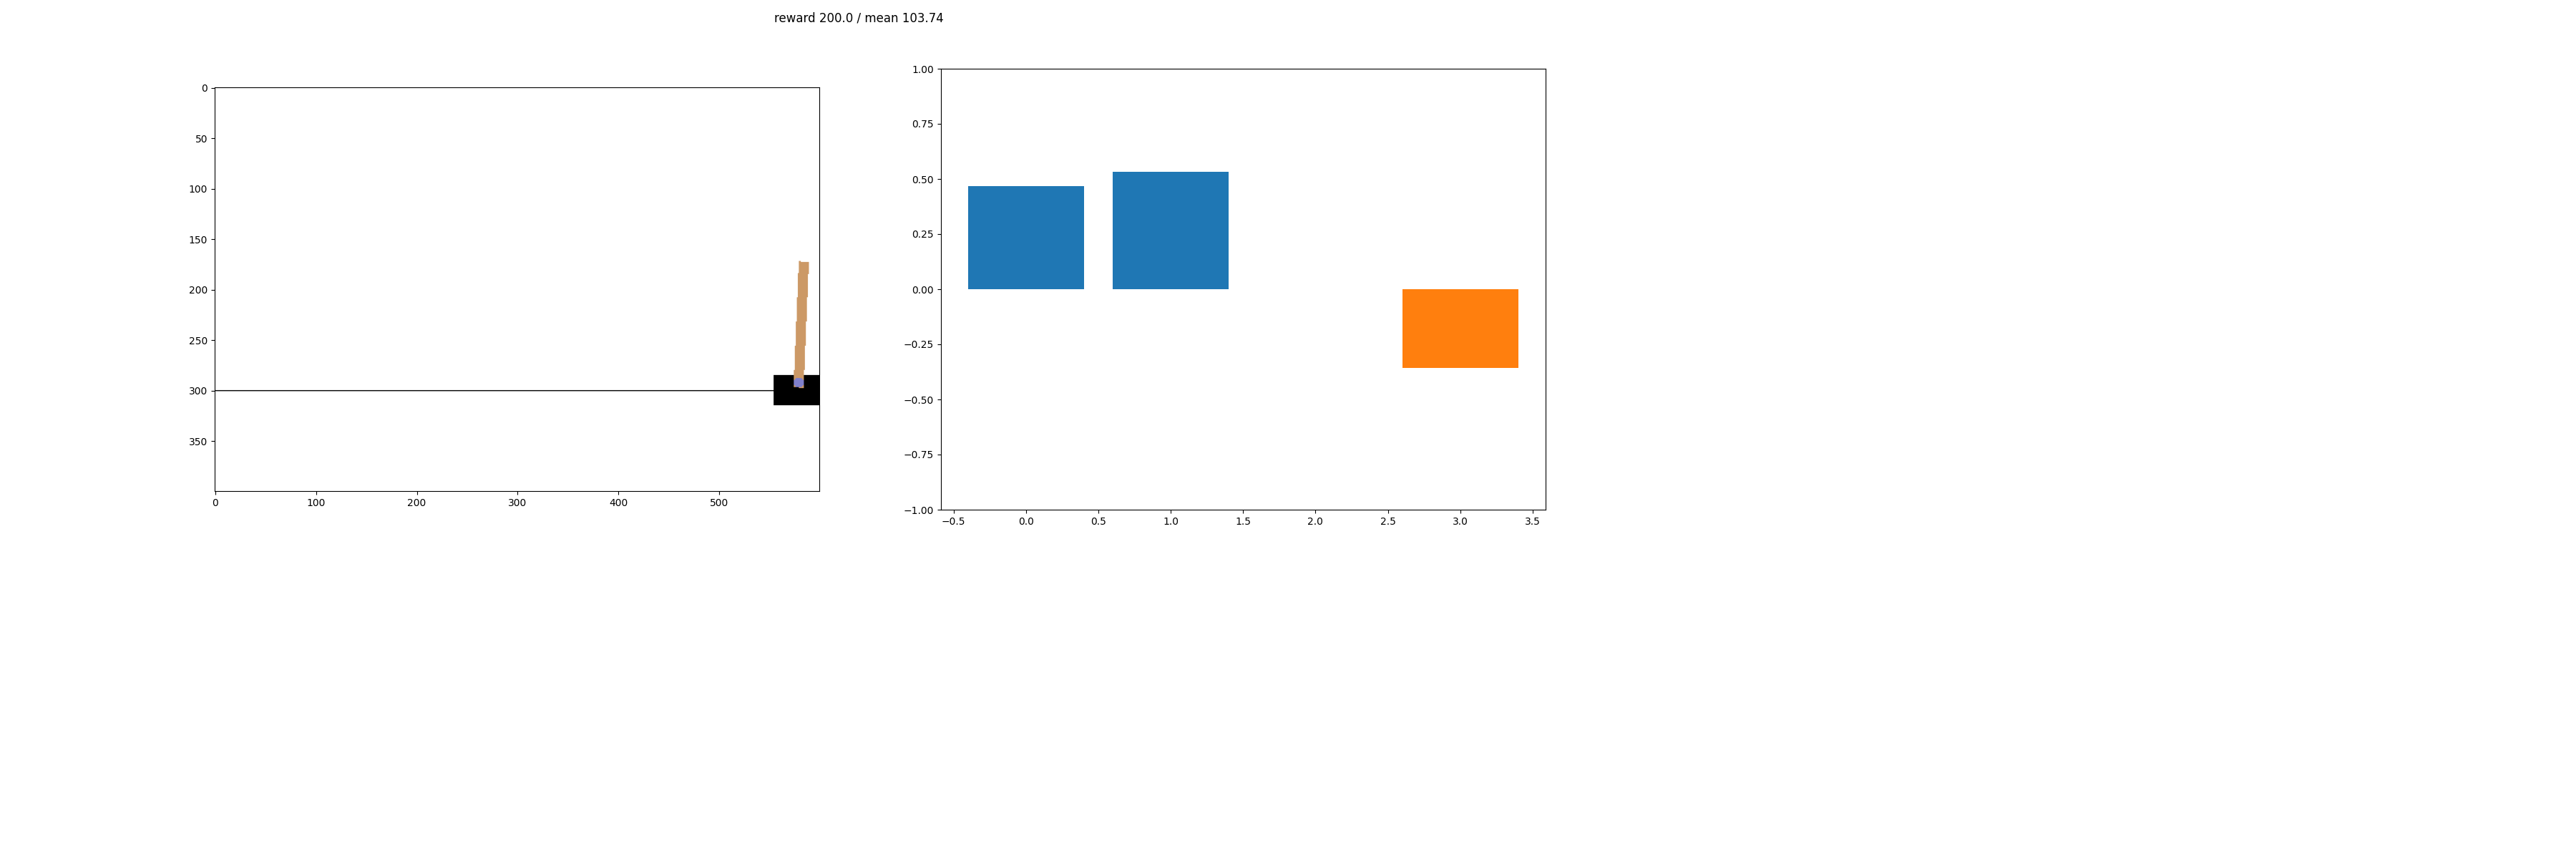

Solved 200.0 (mean 103.74483615123987) in 73 episodes


103.74483615123987

In [21]:
# Now with a Dueling Network !! 
import torch as T
import torch.nn as nn
from torch.optim import RMSprop
from pandas_ml_quant_rl import Agent
from pandas_ml_quant_rl.model.policy.pytorch import PolicyNetwork, DQN_Policy


class DuelingDQNet(PolicyNetwork):
    
    def __init__(self, input_size, n_actions):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )
        
        self.fc_adv = nn.Sequential( 
            nn.Linear(8, 4), 
            nn.ReLU(), 
            nn.Linear(4, n_actions) 
        ) 
        self.fc_val = nn.Sequential( 
            nn.Linear(8, 4), 
            nn.ReLU(), 
            nn.Linear(4, 1) 
        )

    def render(self, states, ax):
        value = self.fc_adv(self.net(states[0])).mean().cpu().detach().item()
        probs = self.softmax(self._estimate_action(*states)).detach().cpu().numpy()[-1]
        ax.clear()
        ax.set_ylim(-1, 1)
        ax.bar(x=range(len(probs)), height=probs)
        ax.bar(x=[3], height=value)

    def get_value_for(self, states, action):
        return self._estimate_action(*states) \
                   .gather(dim=1, index=T.LongTensor(action).to(self.device).unsqueeze(-1))

    def get_state_value(self, states):
        values = self._estimate_action(*states).detach()
        return values.max(dim=1)

        
    def _estimate_action(self, state, state_2):
        x = self.net(state)
        val = self.fc_val(x) 
        adv = self.fc_adv(x) 
        return val + adv - adv.mean()



policy2 = DQN_Policy(
    lambda: DuelingDQNet(env.observation_space.shape[0], 2).cpu(),
    optimizer=lambda p: RMSprop(p),
    batch_size=128,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 150
)

agent2 = Agent(render_nr_actions=-1, render_env=True, render_policy=True)
agent2.learn_to_play(env, policy2, exit_criteria=lambda reward, cnt: reward > 100 or cnt > 500)

In [7]:
IFrame('http://localhost:6006/', width='100%', height='800px')

<IPython.core.display.Javascript object>


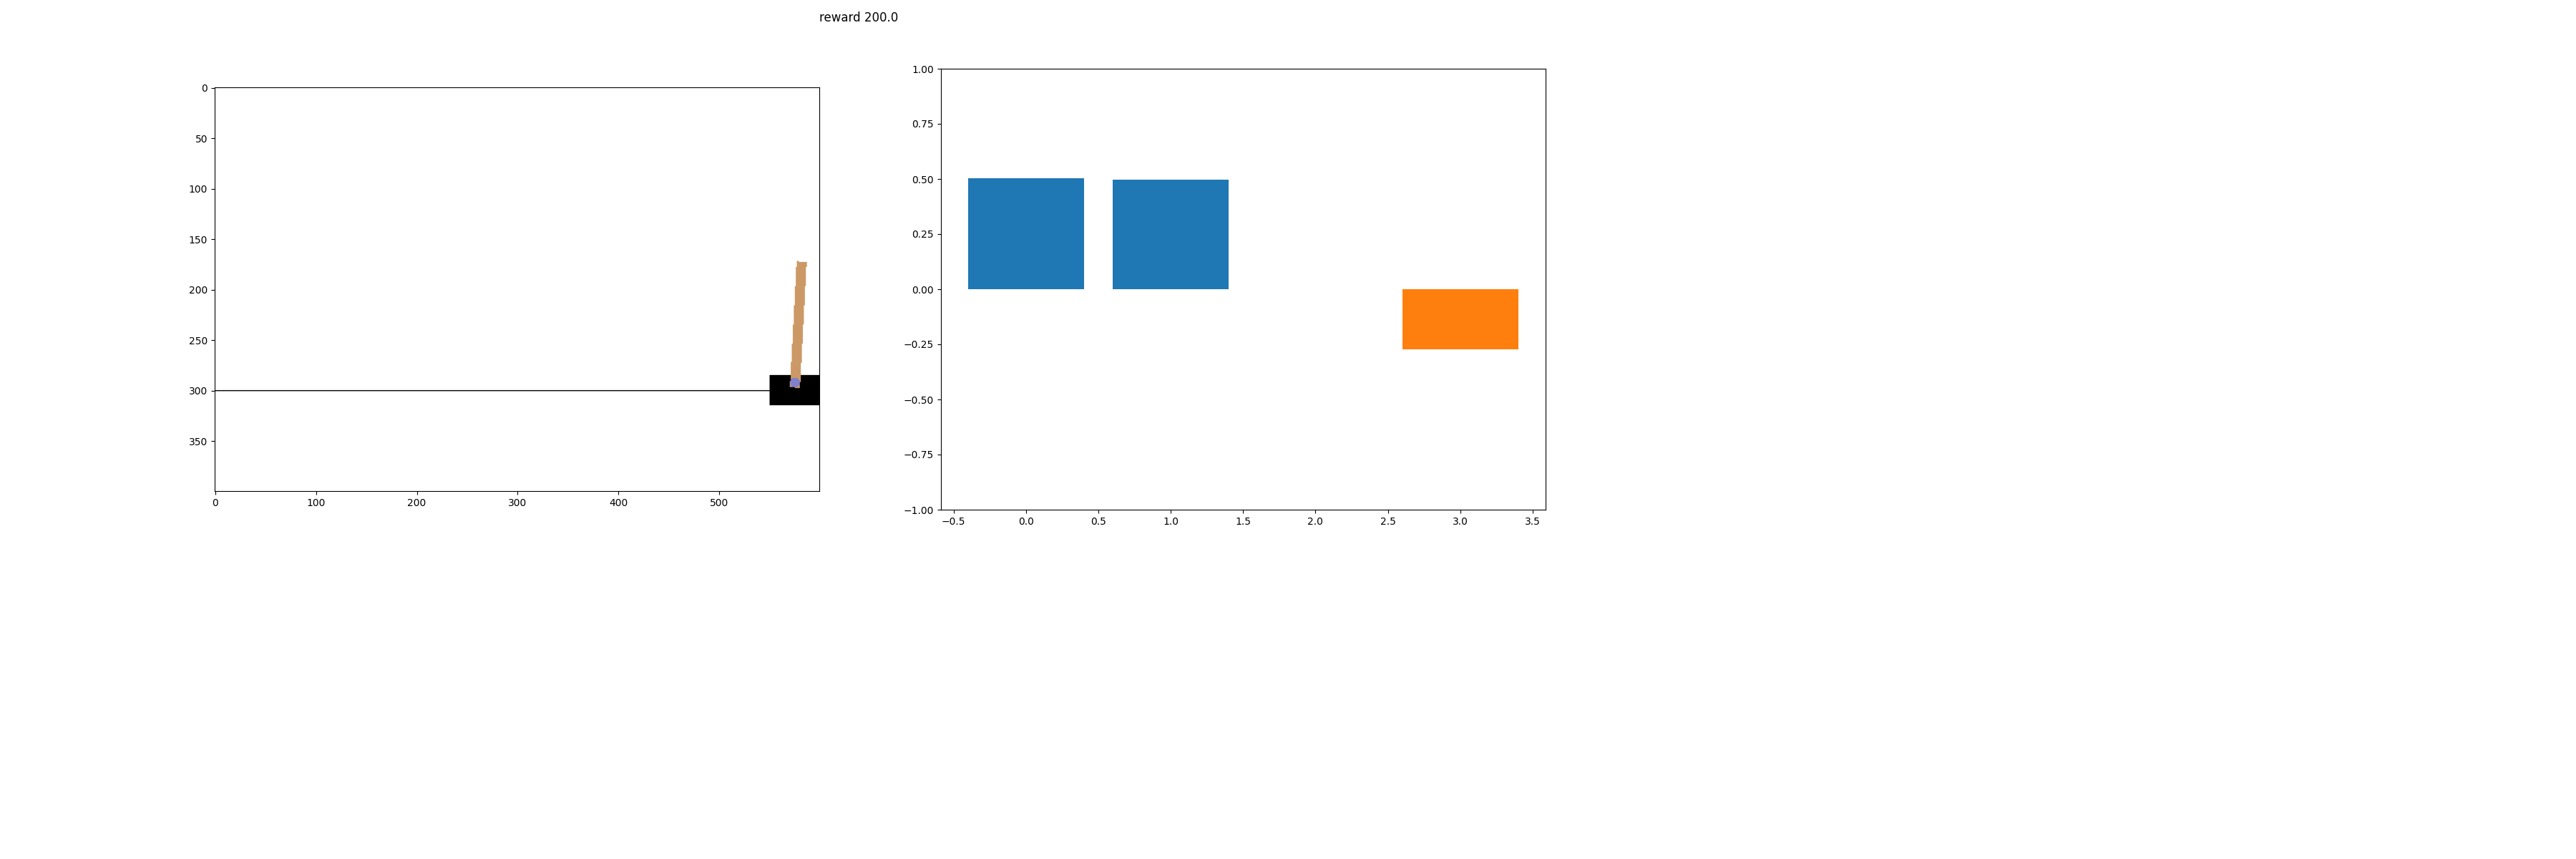

200.0

In [22]:
Agent(render_nr_actions=1, render_env=True, render_policy=True).play_one_episode(env, policy2)

<IPython.core.display.Javascript object>


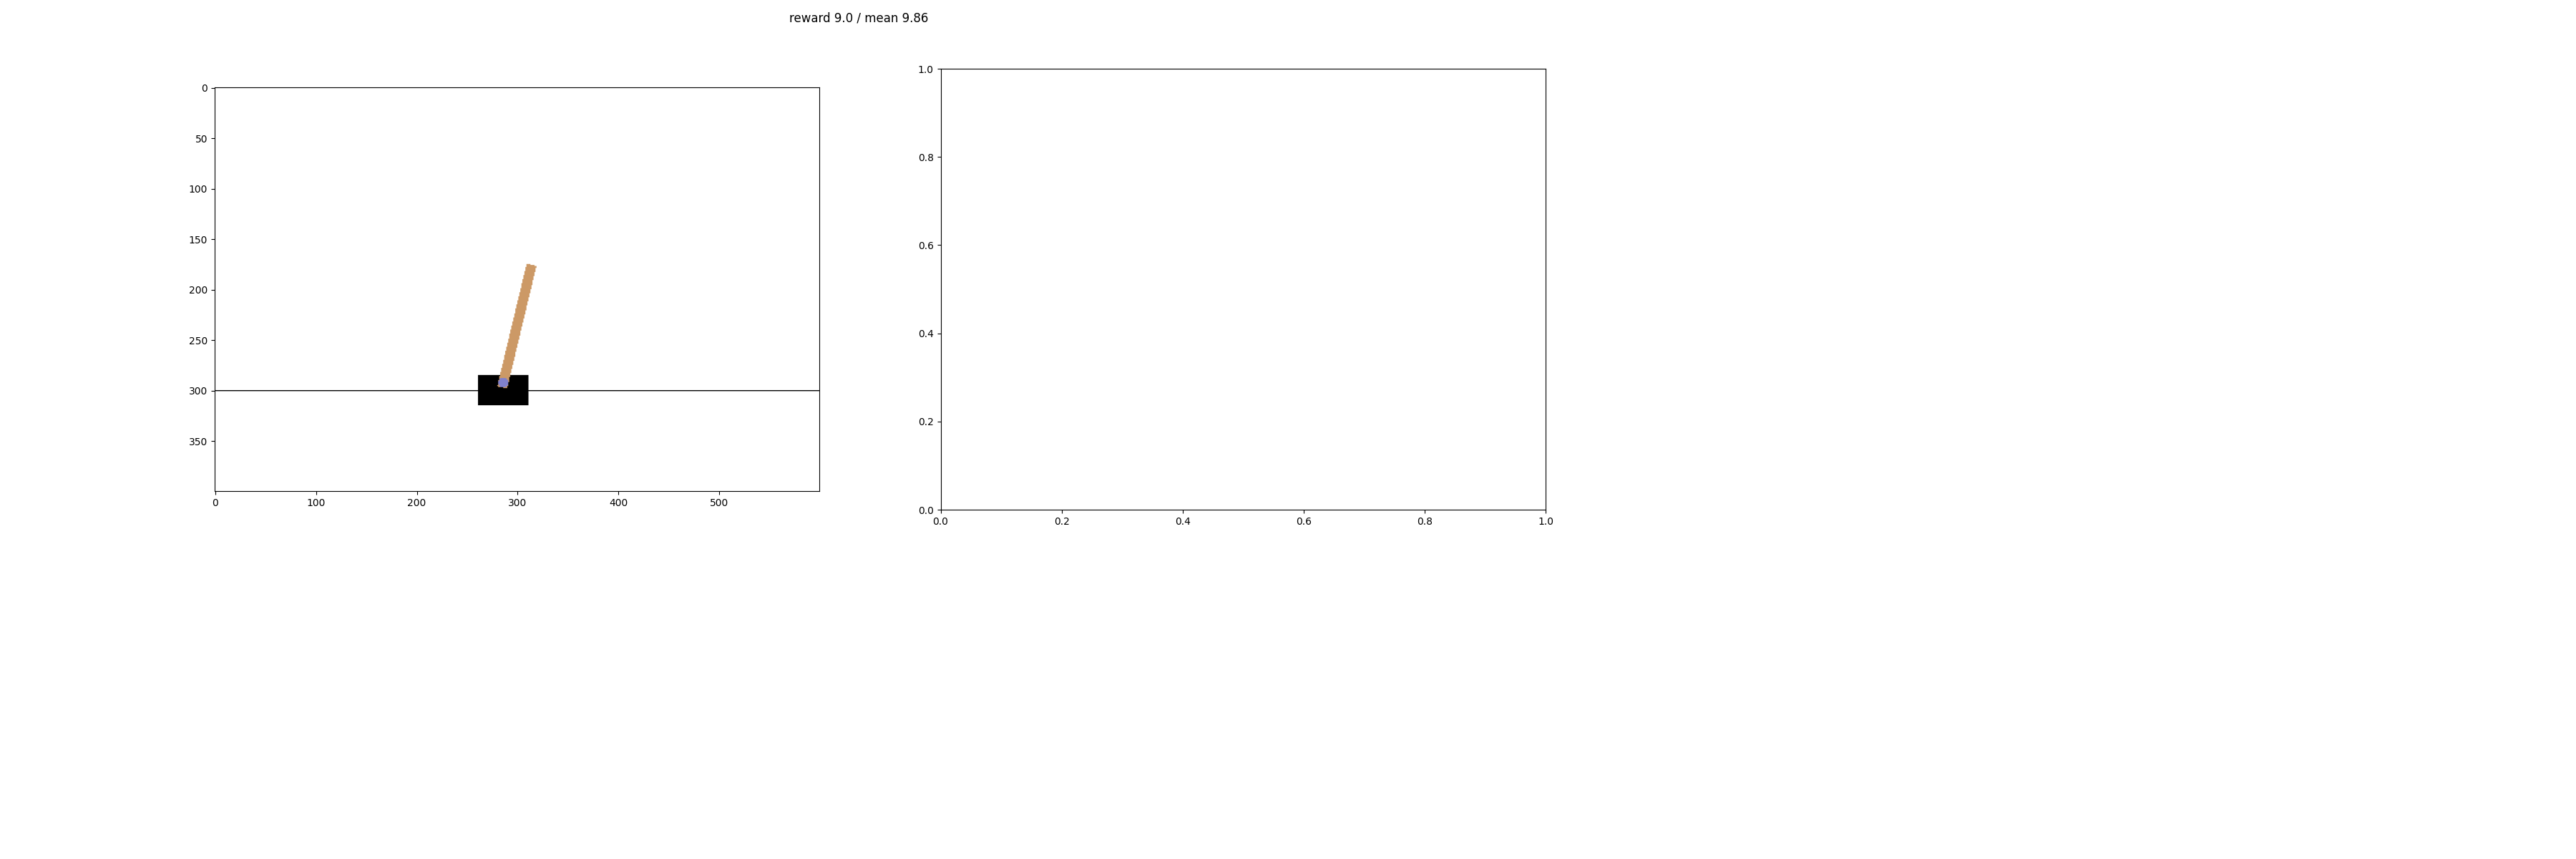

Solved 9.0 (mean 9.860774322527064) in 501 episodes


9.860774322527064

In [24]:
# Now with a Probabilistic Network (QR_DQN) !! 
import torch as T
import torch.nn as nn
from torch.optim import RMSprop
from pandas_ml_quant_rl import Agent
from pandas_ml_quant_rl.model.policy.pytorch import PolicyNetwork, DQN_Policy, QuantileHuberLoss

class QR_DQN(PolicyNetwork):
    def __init__(self, input_size, n_actions, n_qunatiles=32):
        super().__init__()
        self.n_actions = n_actions
        self.n_qunatiles = n_qunatiles
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions * n_qunatiles)
        )
        

    def get_value_for(self, states, action):
        probs = self._estimate_action(*states)
        index = T.LongTensor(action).unsqueeze(-1).unsqueeze(-1).expand(probs.shape[0], self.n_qunatiles, 1)
        return probs.gather(dim=2, index=index)

    def get_state_value(self, states):
        probs = self._estimate_action(*states)
        
        return (
            probs \
                .gather(dim=2, index=T.argmax(probs.mean(dim=1), dim=1, keepdim=True).unsqueeze(-1).expand(probs.shape[0], self.n_qunatiles, 1)) \
                .transpose(1, 2),
            T.argmax(probs.mean(dim=1), dim=1)
        )

    def _estimate_action(self, state, state_2):
        x = self.net(state)
        return x.view(state.shape[0], self.n_qunatiles, self.n_actions)
    


policy3 = DQN_Policy(
    lambda: QR_DQN(env.observation_space.shape[0], 2).cpu(),
    optimizer=lambda p: RMSprop(p),
    objective=QuantileHuberLoss(),
    batch_size=32,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 200,
    nr_episodes_update_target=0.01
)

agent2 = Agent(render_nr_actions=-1, render_env=True, render_policy=True)
agent2.learn_to_play(env, policy3, exit_criteria=lambda reward, cnt: reward > 100 or cnt > 500)

In [10]:
IFrame('http://localhost:6006/', width='100%', height='800px')

In [30]:
# now lets try a Long Only Treding Strategy
import torch as T
import torch.nn as nn
from torch.optim import RMSprop
from pandas_ml_quant_rl import Agent
from pandas_ml_quant_rl.cache import MemCache
from pandas_ml_quant_rl.environments import RandomAssetEnv
from pandas_ml_quant_rl.environments.strategies import LongOnly
from pandas_ml_quant_rl.model.policy.pytorch import PolicyNetwork, DQN_Policy

from pandas_ml_utils import FeaturesAndLabels
from pandas_ml_quant import pd
from pandas_ml_quant_data_provider import fetch_yahoo

env = RandomAssetEnv(
    FeaturesAndLabels(
        features=
            [
                lambda df: df.ta.candle_category().ta.one_hot_encode_discrete(offset=-15, nr_of_classes=30).ta.rnn(10)
            ],

        labels=[],
    ),
    ["SPY", "GLD", "DIA", "QQQ", "RUT", "SLV"],
    strategy=LongOnly(),
    pct_train_data=0.8,
    max_steps=50,
    min_training_samples=50,
    use_cache=MemCache(fetch_yahoo),
)



In [63]:
class DuelingDQNetStrategy(PolicyNetwork):
    
    def __init__(self, obs_space, n_actions):
        
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.Tanh(),
            nn.Linear(16, 8),
        )
        
        self.fc_adv = nn.Sequential( 
            nn.Linear(8, 4), 
            nn.ReLU(), 
            nn.Linear(4, n_actions) 
        ) 
        self.fc_val = nn.Sequential( 
            nn.Linear(8, 4), 
            nn.ReLU(), 
            nn.Linear(4, 1) 
        )

    def render(self, states, ax):
        value = self.fc_adv(self.net(states[0])).mean().cpu().detach().item()
        probs = self.softmax(self._estimate_action(*states)).detach().cpu().numpy()[-1]
        ax.clear()
        ax.set_ylim(-1, 1)
        ax.bar(x=range(len(probs)), height=probs)
        ax.bar(x=[3], height=value)

    def get_value_for(self, states, action):
        return self._estimate_action(*states) \
                   .gather(dim=1, index=T.LongTensor(action).to(self.device).unsqueeze(-1))

    def get_state_value(self, states):
        values = self._estimate_action(*states).detach()
        return values.max(dim=1)

        
    def _estimate_action(self, state, state_2):
        x = self.net(state)
        val = self.fc_val(x) 
        adv = self.fc_adv(x) 
        return val + adv - adv.mean()


In [ ]:
policy = DQN_Policy(
    lambda: DuelingDQNetStrategy(env.observation_space, env.action_space.n).cpu(),
    optimizer=lambda p: RMSprop(p),
    batch_size=128,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 150
)

agent = Agent(render_nr_actions=-1, render_env=True, render_policy=True)
agent.learn_to_play(env, policy, exit_criteria=lambda reward, cnt: reward > 100 or cnt > 500)

In [67]:
env.observation_space

Box(10, 1, 30)